<a href="https://colab.research.google.com/github/Saikat-too/Neural_Network_From_Scratch/blob/main/build_makemore_mlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt' , 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mapping to / from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i , s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s , i in stoi.items() }
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# Build the dataset

block_size = 3 # context length : how many characters do we need to make the prediction

def build_dataset(words):

  X = []
  Y = []
  for w in words:
  #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '-->' , itos[ix])
      context = context[1:] + [ix] #Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X , Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr , Ytr = build_dataset(words[:n1])       # 80%
Xdev , Ydev = build_dataset(words[n1:n2])   # 10%
Xte , Yte = build_dataset(words[n2:])       # 10%

In [7]:
# MLP revisited
n_embd = 10     # The dimensionality of the character embedding vectors
n_hidden = 200  # The number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size , n_embd) ,             generator=g)
W1 = torch.randn((n_embd * block_size , n_hidden) , generator=g)   * (5/3) / ((n_embd * block_size)**0.5)

# b1 = torch.rand((n_hidden) ,                        generator=g)   * 0.01
W2 = torch.randn((n_hidden , vocab_size) ,          generator = g) * 0.01
b2 = torch.randn((vocab_size) ,                     generator = g) * 0
bngain = torch.ones((1 , n_hidden))
bnbias = torch.zeros((1 , n_hidden))
bmean_running = torch.zeros((1  , n_hidden))
bstd_running  = torch.ones((1 , n_hidden))
parameters = [C , W1 ,  W2 , b2 ,bngain , bnbias ]

for p in parameters:
  p.requires_grad = True

In [8]:
# Optimization

max_steps = 200001
batch_size = 32
lossi = []

for i in range(max_steps):

  # mini batch construct
  ix = torch.randint(0 , Xtr.shape[0] , (batch_size , ) , generator = g)
  Xb , Yb = Xtr[ix] , Ytr[ix]

  #Forward Pass
  emb = C[Xb]
  embcat = (emb.view(emb.shape[0] , -1))
  #Linear Layer
  hpreact = embcat @ W1  # b1
  # Batch Norm
  bmeani = hpreact.mean(0 , keepdim=True)
  bstdi =  hpreact.std(0 , keepdim=True)
  hpreact = bngain * (hpreact - bmeani ) / bstdi  + bnbias
  with torch.no_grad():
    bmean_running =  0.999 * bmean_running + 0.001 *  bmeani
    bstd_running  = 0.999 * bstd_running  + 0.001 * bstdi
  # Non Linearity
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits , Yb)


  # Backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # Track Stats

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps}: {loss.item():.4f}')
  lossi.append(loss.log10().item())




      0/200001: 3.3239
  10000/200001: 2.0322
  20000/200001: 2.5675
  30000/200001: 2.0125
  40000/200001: 2.2446
  50000/200001: 1.8897
  60000/200001: 2.0785
  70000/200001: 2.3681
  80000/200001: 2.2918
  90000/200001: 2.0238
 100000/200001: 2.3673
 110000/200001: 2.3132
 120000/200001: 1.6414
 130000/200001: 1.9311
 140000/200001: 2.2231
 150000/200001: 2.0027
 160000/200001: 2.0997
 170000/200001: 2.4949
 180000/200001: 2.0199
 190000/200001: 2.1707
 200000/200001: 2.1862


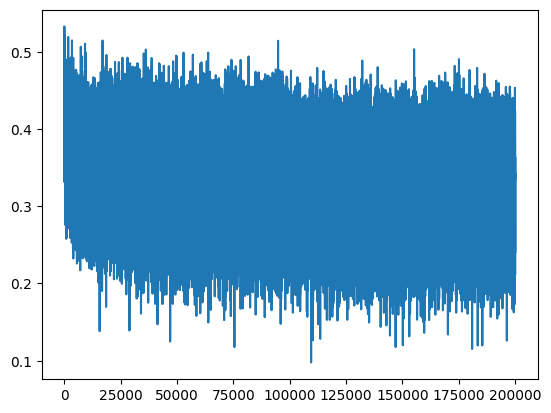

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
  x , y = {
      'train' : (Xtr , Ytr) ,
      'val'   : (Xdev , Ydev),
      'test'  : (Xte , Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0] , -1)
  hpreact = (embcat @ W1 )
  hpreact = bngain * (hpreact - bmean_running) /  bstd_running  + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits , y)
  print(split , loss.item())

split_loss('train')
split_loss('val')

train 2.067310333251953
val 2.1055855751037598


In [13]:
# sample from the model

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):

    out = []
    context = [0] * block_size

    while True:
      # Forward pass the neural net
      emb = C[torch.tensor([context])]
      h   = torch.tanh(emb.view(1 , -1 ) @ W1 ) # + b1
      logits = h @ W2 + b2
      probs = F.softmax(logits , dim=1)
      #sample from the distribution
      ix = torch.multinomial(probs , num_samples=1 , generator=g).item()
      # shift the context window and track the sample
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0 :
        break

    print(''.join(itos[i] for i in out))

briahgmnazzierstel.
fhal.
qetvangendra.
zasderidgmlillshi.
jedrikelssandvannellyssllyaphn.
shdumrithghnestli.
jewtdvi.
xibuscfsubferndersymusemels.
kaylahshmyah.
haz.
sadya.
sufizajahkirrentirbbisvekostep.
qwilfeyroshbh.
zprixabumushwa.
hmarishid.
qinfelvshlwaldarikthrishthzighikassmitgftrvissivishten.
riefhrriyaxabushdumichekitya.
blvardtai.
bdgihzirrlq.
saadenaysophlrystta.



## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491


In [30]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

#layers = [
#  Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [38]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
    # break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.1831
  10000/ 200000: 2.0970
  20000/ 200000: 2.0614
  30000/ 200000: 2.4398
  40000/ 200000: 2.1768
  50000/ 200000: 2.0377
  60000/ 200000: 2.1667
  70000/ 200000: 2.2049
  80000/ 200000: 1.9625
  90000/ 200000: 2.0611
 100000/ 200000: 1.8088
 110000/ 200000: 2.1905
 120000/ 200000: 1.9137
 130000/ 200000: 2.1345
 140000/ 200000: 1.5340
 150000/ 200000: 2.1427
 160000/ 200000: 1.9553
 170000/ 200000: 2.0292
 180000/ 200000: 1.7984
 190000/ 200000: 2.0000


layer 2 (      Tanh): mean -0.00, std 0.83, saturated: 37.69%
layer 5 (      Tanh): mean -0.01, std 0.88, saturated: 52.75%
layer 8 (      Tanh): mean -0.00, std 0.89, saturated: 54.69%
layer 11 (      Tanh): mean +0.00, std 0.91, saturated: 59.78%
layer 14 (      Tanh): mean -0.01, std 0.91, saturated: 59.41%


Text(0.5, 1.0, 'Activation Distribution')

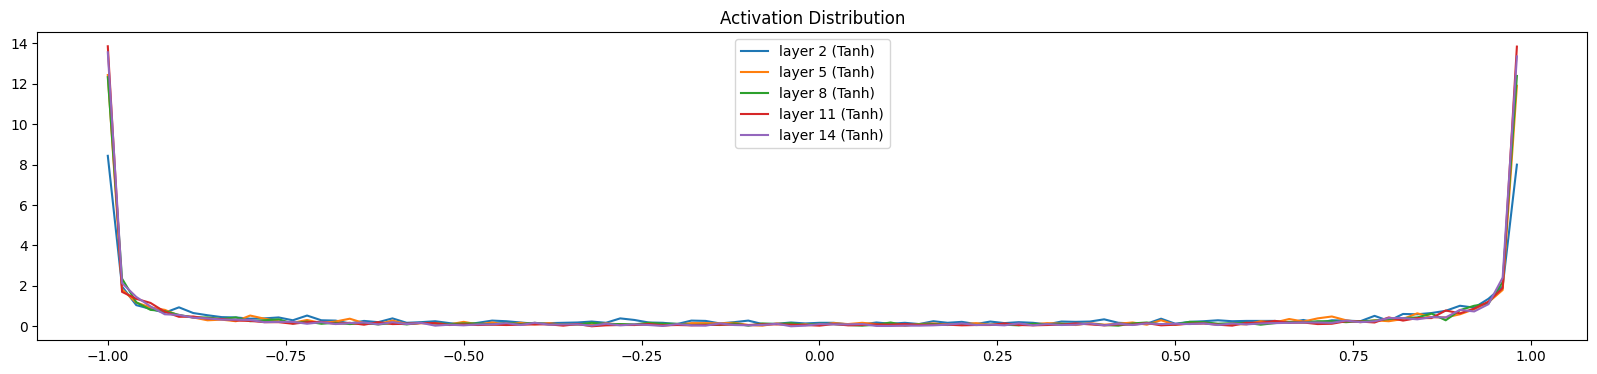

In [39]:
# Visualize Histogram
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]):
  if isinstance(layer , Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy , hx = torch.histogram(t , density=True)
    plt.plot(hx[:-1].detach() , hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')\

plt.legend(legends)
plt.title('Activation Distribution')



layer 2 (      Tanh): mean +0.000004, std 3.109200e-03
layer 5 (      Tanh): mean +0.000021, std 2.877520e-03
layer 8 (      Tanh): mean -0.000013, std 3.052897e-03
layer 11 (      Tanh): mean +0.000056, std 3.253379e-03
layer 14 (      Tanh): mean +0.000060, std 4.213584e-03


Text(0.5, 1.0, 'gradient distribution')

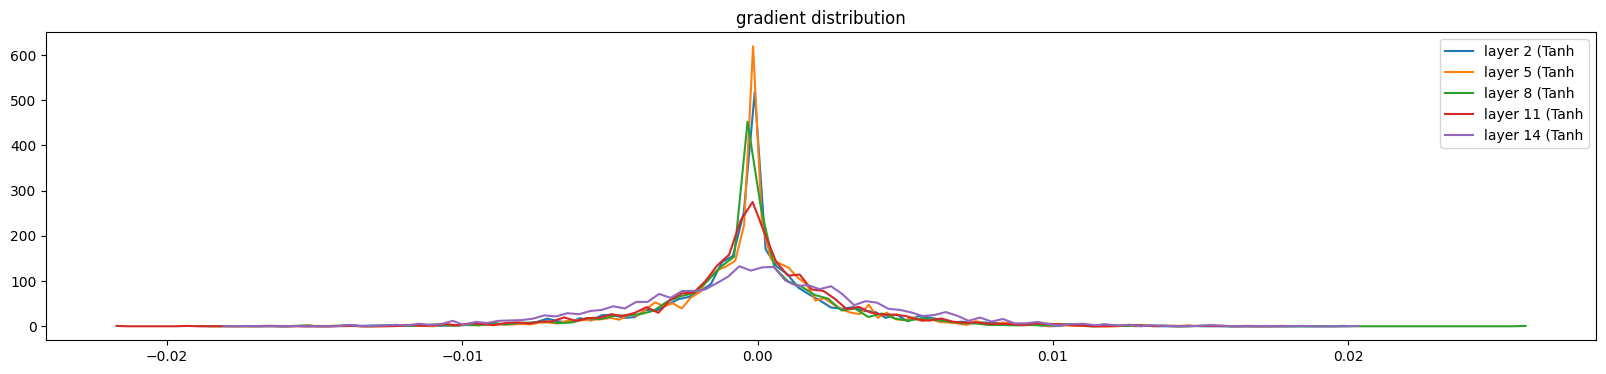

In [40]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


weight   (27, 10) | mean -0.000169 | std 1.248340e-02 | grad:data ratio 1.013767e-02
weight  (30, 100) | mean -0.000092 | std 7.154796e-03 | grad:data ratio 1.440426e-02
weight (100, 100) | mean +0.000063 | std 4.412543e-03 | grad:data ratio 1.475248e-02
weight (100, 100) | mean -0.000005 | std 4.564234e-03 | grad:data ratio 1.566263e-02
weight (100, 100) | mean +0.000000 | std 5.249278e-03 | grad:data ratio 1.845397e-02
weight (100, 100) | mean +0.000049 | std 5.963226e-03 | grad:data ratio 2.130491e-02
weight  (100, 27) | mean -0.000008 | std 1.320171e-02 | grad:data ratio 3.565834e-02


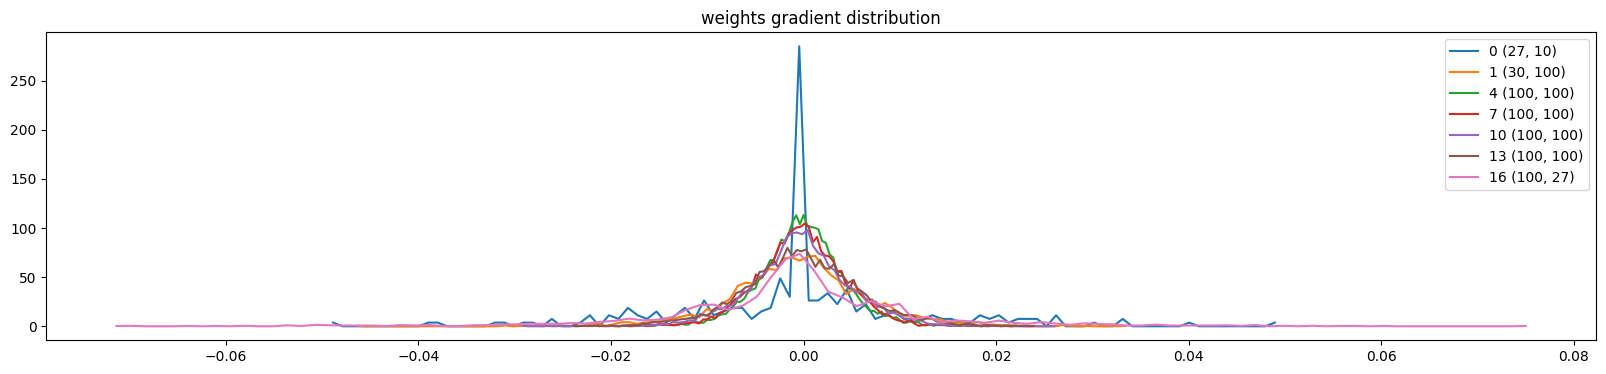

In [41]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


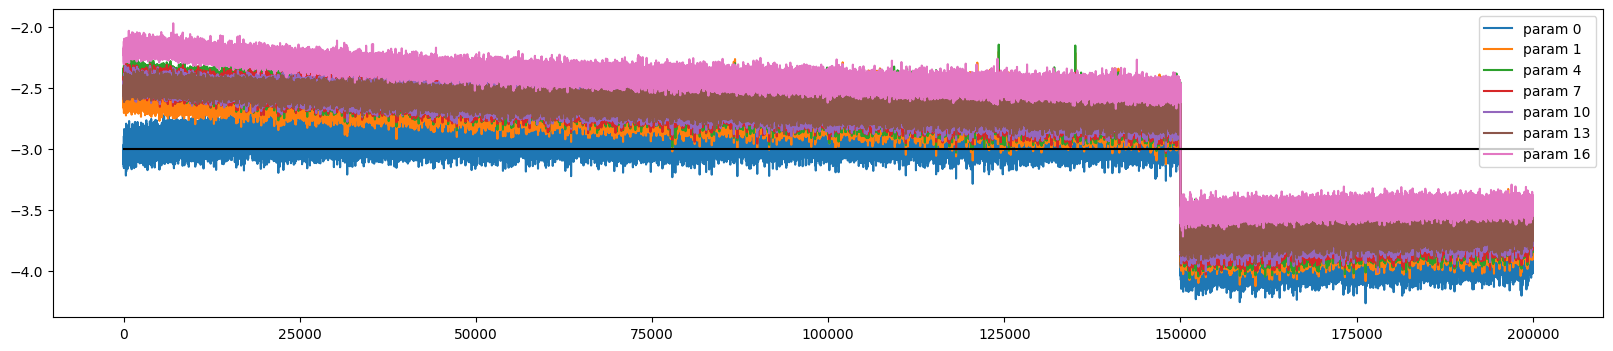

In [42]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [43]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9587448835372925
val 2.0775187015533447


In [44]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
madhayla.
remmadiendra.
kalie.
korelin.
shi.
jenneden.
edoraan.
kayzion.
kamin.
shubergiagrael.
kin.
renlynn.
novana.
ubakynder.
yarue.
elsy.
majahsanyah.
hal.
